In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit

#### Auxiliar Functions

In [17]:
###
class AccessLog:
    """ All operation in AccessLog (AL) """
    def __init__(self, df_users, df_rscs) -> None:
        """ Initialize AL attributes """
        self.df_users = df_users
        self.df_rscs = df_rscs
        self.user_attrs = df_users.columns
        self.rsrc_attrs = df_rscs.columns
        self.universal_access_log = []
    
    def compute_universal_al(self) -> None:
        """ Compute the universal Access Log (UAL). |UAL| = |U| x |R|"""
        access_log = []
        for user in self.df_users.values:
            for res in self.df_rscs.values:        
                access_log.append(list(user) + list(res))
        
        access_log = pd.DataFrame(access_log)
        access_log.columns = self.df_users.columns.append(self.df_rscs.columns)
        self.universal_access_log = access_log

    def policy_evaluation(self, policy) -> None:
        """ Compare each access record with a policy set."""
        false_negs = [] # False negatives
        true_pos = [] # True positives
        len_policy = len(policy)

        for acc_req in self.universal_access_log.iloc:
            denies_count = 0
            for rule in policy:
                res = True
                for item_rule in rule:
                    if item_rule[0] == 0:
                        if acc_req[item_rule[1]] != item_rule[2]:
                            res = False
                            break
                    if item_rule[0] == 1: # => attr1.val = attr2.val
                        if acc_req[item_rule[1]] != acc_req[item_rule[2]]:
                            res = False
                            break

                if res == False:
                    denies_count += 1
            if denies_count == len_policy:
                false_negs.append(acc_req)
            else:
                true_pos.append(acc_req)
        
        false_negs = pd.DataFrame(false_negs)
        true_pos = pd.DataFrame(true_pos)

        print("FN;", len(false_negs), "\t\tTP:", len(true_pos))

        # Add "ACTION" column
        false_negs["ACTION"] = 0
        true_pos["ACTION"] = 1

        # Access log with "ACTION" column
        self.universal_access_log = pd.concat([true_pos,false_negs])

    def get_sparse_al(self, fraction, random_state=None, previous_al=None):        
        """ Compute the sparse access log (SAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al
        sparse_positive_al = None   
        pos_access_req = acc_log[acc_log["ACTION"]==1]
        if random_state != None:
            sparse_positive_al = pos_access_req.sample(frac=fraction,
                                                       random_state=random_state)
        else:
            sparse_positive_al = pos_access_req.sample(frac=fraction)

        return pd.concat([sparse_positive_al, acc_log[acc_log["ACTION"]==0]])

    def get_noisy_al(self, fraction, random_state=None, previous_al=None):
        """ Compute the noisy access log (NAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al

        noysi_al = None
        if random_state != None:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction,
                                                      random_state = random_state)
        else:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction)
        
        noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                        
        noisy_acc_req = None
        normal_acc_req = None
        for noisy_idx, normal_idx, in noisy_acc_log_selection:
            noisy_acc_req = acc_log.iloc[noisy_idx]
            normal_acc_req = acc_log.iloc[normal_idx]

        # Change the resolution in the noisy_selection dataset
        noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)

        noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

        return noysi_al

    def get_balanced_al(self, positive_frac, random_state = None, previous_al = None):
        acc_log = self.universal_access_log
        
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al        

        # Compute the original balanced
        pos_acc_log = acc_log[acc_log["ACTION"]==1]
        neg_acc_log = acc_log[acc_log["ACTION"]==0]

        len_al = len(acc_log)
        len_pos_ar = len(pos_acc_log)

        limit_positive_frac = ( len_pos_ar * 100 ) / len_al

        if positive_frac < limit_positive_frac and positive_frac > 1:
            print("Is not possible")
            return
        
        len_neg_ar = int(( (1-positive_frac) * 100 * len_pos_ar ) / (positive_frac*100))        

        neg_acc_req = []
        if random_state != None:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar,
                                             random_state=random_state)
        else:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar)

        return pd.concat([pos_acc_log, neg_acc_req])

        


In [27]:
fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")
fpath2 = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")

### HC

##### Policy

In [8]:
### Policy
# 0 = attribute = value
# 1 = attribute = attribute => attribute.value = attribute.value
policy_hc = [
    [
        [0, "position", "nurse"],
        [0, "type", "HR"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HR"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HR"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HR"],
        [1, "patient", "agentfor"]
    ],

    [
        [0, "type", "HRItem"],
        [1, "uname", "author"]
    ],
    [
        [0, "position", "nurse"],
        [0, "type", "HRItem"],
        [0, "topics", "nursing"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HRItem"],
        [1, "topics", "specialties"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "patient", "agentfor"]
    ]
]

# Policy summary
counter_len = 0
for rule in policy_hc:
    counter_len += len(rule)
print("|R|", len(policy_hc))
print("avg(R)", counter_len/len(policy_hc))
print("WSC", counter_len)


|R| 9
avg(R) 2.6666666666666665
WSC 24


##### Data

In [6]:
### Load data

# Load users
filepath = "../data/test.log"
df_users = pd.read_csv(filepath)
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users
print("###*** DF - USERS - DONE!***###")

# Load resources
filepath = "../data/HC-res.csv"
df_res = pd.read_csv(filepath)
df_res = df_res[df_res.columns[1:]] # Remove the ID
df_res = df_res.drop_duplicates() # Remove deplicated resources
print("###*** DF - RESOURCES - DONE!***###")

###*** DF - USERS - DONE!***###
###*** DF - RESOURCES - DONE!***###


In [7]:
### Preprocessing in resources 

# All possible combination
uniques = [df_res[i].unique().tolist() for i in df_res.columns]
df_res = pd.DataFrame(product(*uniques), columns = df_res.columns)
df_res["rname"] = df_res.index
print("Done")

,type,author,patient,topics,tratingTeam,rward,rname
0,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,HRitem,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...
4955,HR,carAgent1,carPat1,cardiology,oncTeam2,carward,4955
4956,HR,carAgent1,carPat1,cardiology,carTeam1,oncward,4956
4957,HR,carAgent1,carPat1,cardiology,carTeam1,carward,4957
4958,HR,carAgent1,carPat1,cardiology,carTeam2,oncward,4958


In [18]:
#### Access Log object

hc_acc_log = AccessLog(df_users=df_users, df_rscs=df_res)

# Compute access log universal
hc_acc_log.compute_universal_al()

# Compute the decision for each access requests
hc_acc_log.policy_evaluation(policy_hc)

FN; 133920 		TP: 19840


In [40]:
hc_sparse_al = hc_acc_log.get_sparse_al(0.5)

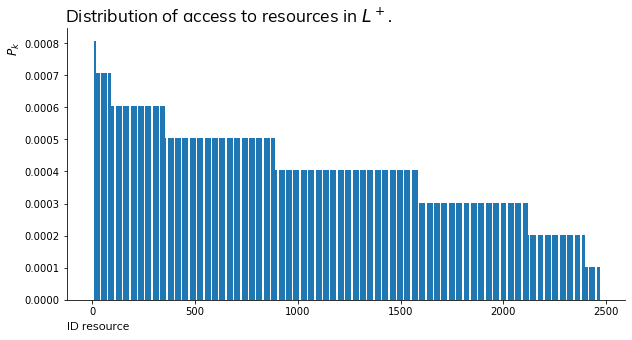

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = hc_sparse_al[hc_sparse_al.ACTION==1].rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [51]:
hc_noisy_al = hc_acc_log.get_noisy_al(0.25)

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


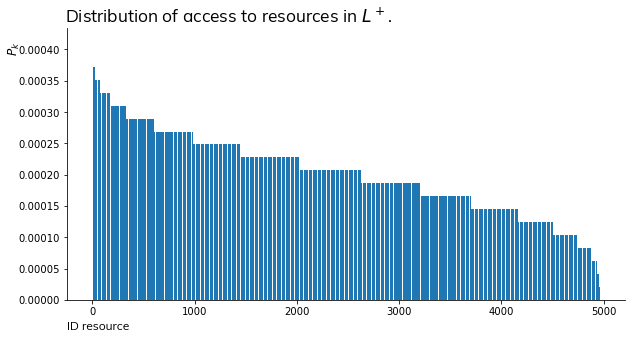

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = hc_noisy_al[hc_noisy_al.ACTION==1].rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [32]:
data_ = hc_acc_log.universal_access_log[hc_acc_log.universal_access_log.ACTION==1]

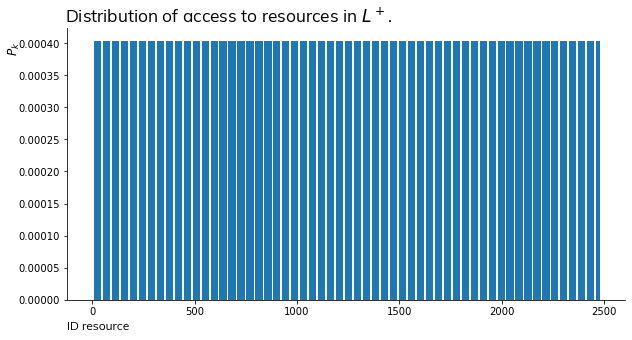

In [33]:
data_ = hc_acc_log.universal_access_log[hc_acc_log.universal_access_log.ACTION==1]
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = data_.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

### PM

In [53]:
policy_pm = [
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "departmentu"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "schedule"],
        [0, "projects", "project"]
    ],
    [
        [0, "type", "task"],
        [0, "task", "rname"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", "0"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "isemployee","0"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "adminroles", "auditor"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "schedule"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ]
]

counter_len = 0
for rule in policy_pm:
    counter_len += len(rule)
print("|R|", len(policy_pm))
print("avg(R)", counter_len/len(policy_pm))
print("WSC", counter_len)


|R| 12
avg(R) 2.8333333333333335
WSC 34


In [54]:
# Load user and resource data
filepath = "../data/PM-users.csv"
df_users = pd.read_csv(filepath) # Users
df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/PM-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

#print(df_users.info(), df_res.info())

In [55]:
df_users_sample = df_users.iloc[46:]
df_users_sample = df_users_sample[["projects", "expertiseu", "isemployee", "task"]]

uniques = [df_users_sample[i].unique().tolist() for i in df_users_sample.columns]
df_users_sample = pd.DataFrame(product(*uniques), columns = df_users_sample.columns)
#df_users_sample["uname"] = df_users_sample.index
df_users_sample

,projects,expertiseu,isemployee,task
0,proj11,design,1,proj11task1a
1,proj11,design,1,proj11task2a
2,proj11,design,1,proj11task1
3,proj11,design,1,proj11task2
4,proj11,design,1,proj11task1propa
...,...,...,...,...
507,proj22,coding,0,proj22task2
508,proj22,coding,0,proj22task1propa
509,proj22,coding,0,proj22task2propa
510,proj22,coding,0,proj22task1prop


In [56]:
df_users_test = df_users.drop(range(46, len(df_users)))
df_users_test = pd.concat([df_users_test, df_users_sample])
df_users_test["uname"] = df_users_test.index
df_users_test

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname
0,accountant,proj11,none,none,none,none,none,0
1,accountant,proj21,none,none,none,none,none,1
2,accountant,proj12,none,none,none,none,none,2
3,accountant,proj22,none,none,none,none,none,3
4,auditor,proj11,none,none,none,none,none,4
...,...,...,...,...,...,...,...,...
507,NaN,proj22,NaN,NaN,coding,0,proj22task2,507
508,NaN,proj22,NaN,NaN,coding,0,proj22task1propa,508
509,NaN,proj22,NaN,NaN,coding,0,proj22task2propa,509
510,NaN,proj22,NaN,NaN,coding,0,proj22task1prop,510


In [59]:
pm_acc_log = AccessLog(df_users_test, df_res)

# Compute access log universal
pm_acc_log.compute_universal_al()

# Compute the decision for each access requests
pm_acc_log.policy_evaluation(policy_pm)

FN; 20640 		TP: 1680


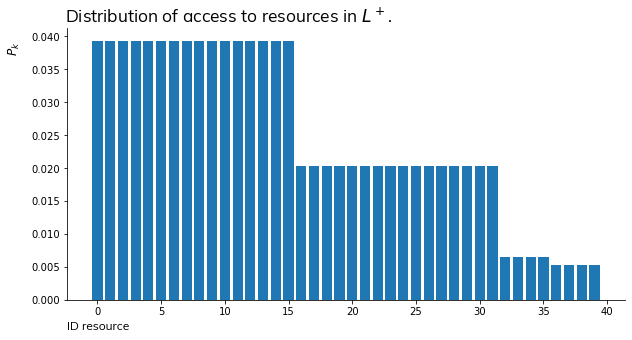

In [63]:
data_ = pm_acc_log.universal_access_log[pm_acc_log.universal_access_log.ACTION==1]
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = data_.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [78]:
pm_sparse_al = pm_acc_log.get_sparse_al(0.5)

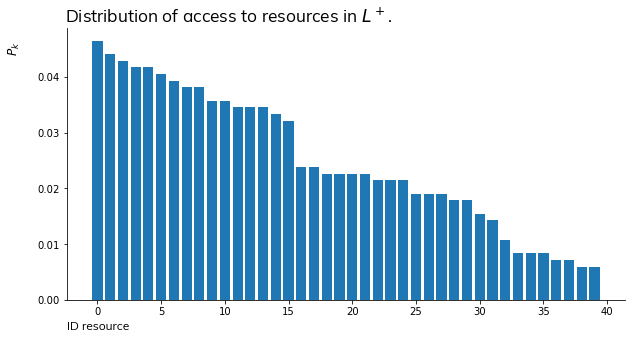

In [79]:
pm_sparse_al = pm_acc_log.get_sparse_al(0.5)
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pm_sparse_al[pm_sparse_al.ACTION==1].rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [88]:
pm_noisy_al = pm_acc_log.get_noisy_al(0.25)

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


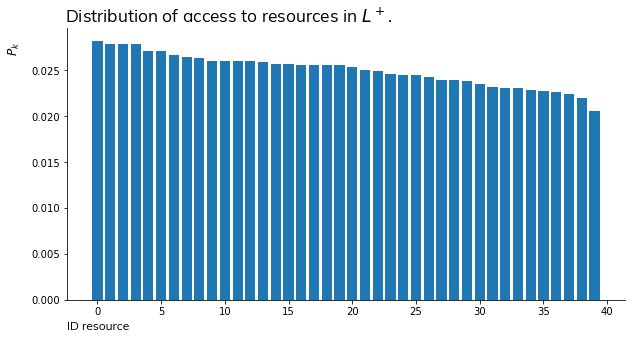

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pm_noisy_al[pm_noisy_al.ACTION==1].rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

### UN

In [90]:
policy_un = [
    [
        [0,"type", "gradebook"],
        [1, "crsTaken", "csr"]
    ],
    [
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "position", "faculty"],
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "roster"]
    ],
    [
        [0, "position", "faculty"],
        [0, "type", "roster"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "type", "transcript"],
        [1, "uname", "student"]
    ],
    [
        [0, "isChair", 1],
        [0, "type", "transcript"],
        [1, "rDepartment", "departmentu"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "transcript"],
    ],
    [
        [0, "type", "application"],
        [1, "uname", "student"]
    ],
    [
        [0, "departmentu", "admissions"],
        [0, "type", "application"],
    ]
]

counter_len = 0
for rule in policy_un:
    counter_len += len(rule)
print("|R|", len(policy_pm))
print("avg(R)", counter_len/len(policy_pm))
print("WSC", counter_len)

|R| 12
avg(R) 1.9166666666666667
WSC 23


In [96]:
# Load user and resource data
filepath = "../data/UN-users.csv"
df_users = pd.read_csv(filepath) # Users
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/UN-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        101 non-null    object
 1   position     101 non-null    object
 2   departmentu  101 non-null    object
 3   crsTaken     101 non-null    object
 4   crsTaught    101 non-null    object
 5   isChair      101 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rName        277 non-null    object
 1   type         277 non-null    object
 2   student      277 non-null    object
 3   rDepartment  277 non-null    object
 4   csr          277 non-null    object
dtypes: object(5)
memory usage: 13.0+ KB
None None


In [97]:
un_acc_log = AccessLog(df_users, df_res)

# Compute access log universal
un_acc_log.compute_universal_al()

# Compute the decision for each access requests
un_acc_log.policy_evaluation(policy_un)

FN; 26955 		TP: 1022


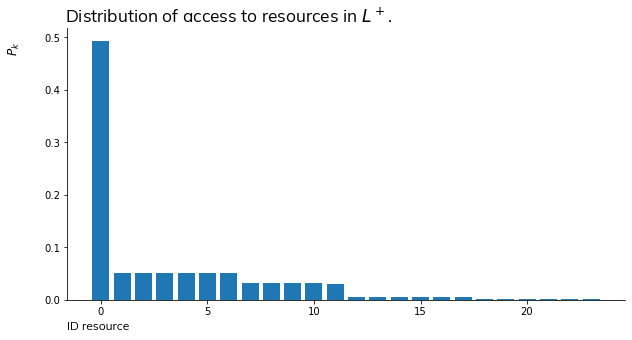

In [99]:
data_ = un_acc_log.universal_access_log[un_acc_log.universal_access_log.ACTION==1]
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = data_.rName.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

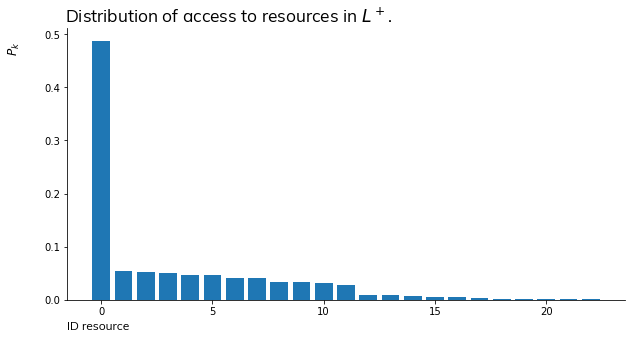

In [104]:
un_sparse_al = un_acc_log.get_sparse_al(0.5)
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = un_sparse_al[un_sparse_al.ACTION==1].rName.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


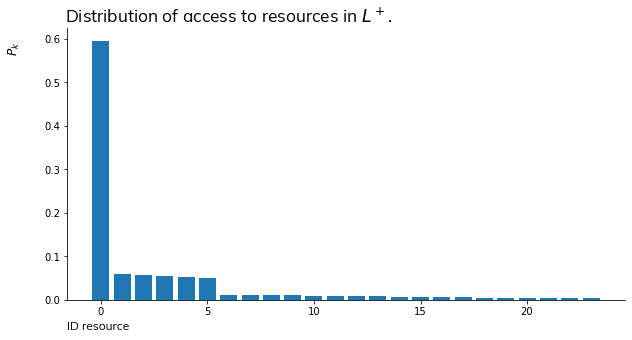

In [109]:
un_sparse_al = un_acc_log.get_noisy_al(0.25)
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = un_sparse_al[un_sparse_al.ACTION==1].rName.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
#plt.savefig("HC-AccessDistribution.svg")
plt.show()